<a href="https://colab.research.google.com/github/Euchigere/PneumoDoc/blob/master/pneumonia_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
%cd /gdrive/My Drive/chest_xray

/gdrive/My Drive/chest_xray


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # %tensorflow_version only exists in colab
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import keras.backend as K
from tensorflow.python.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import os
import numpy as np
import pandas as pd
# import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
train_dir = os.path.join(os.getcwd(), 'train')
dir_pneumonia_train = os.path.join(train_dir, 'PNEUMONIA_train')
dir_normal_train = os.path.join(train_dir, 'NORMAL_train')

val_dir = os.path.join(os.getcwd(), 'validation')
dir_normal_val = os.path.join(val_dir, 'NORMAL_test')
dir_pneumonia_val = os.path.join(val_dir, 'PNEUMONIA_test')

In [0]:
#checking the number of images in each directory
num_pneumonia_train = len(os.listdir(dir_pneumonia_train))
num_pneumonia_val = len(os.listdir(dir_pneumonia_val))
total_pneumonia_images = num_pneumonia_train + num_pneumonia_val

num_normal_train = len(os.listdir(dir_normal_train))
num_normal_val = len(os.listdir(dir_normal_val))
total_normal_images = num_normal_train + num_normal_val

total_train = num_pneumonia_train + num_normal_train
total_val = num_pneumonia_val + num_normal_val

In [0]:
print('total training pneumonia images: ', num_pneumonia_train)
print('total validation pneumonia images: ', num_pneumonia_val)
print('total pneumonia images: ', total_pneumonia_images)

print('\ntotal training normal images: ', num_normal_train)
print('total validation normal images: ', num_normal_val)
print('total normal images: ', total_normal_images)

print('\ntotal train images: ', total_train)
print('\ntotal validation images: ', total_val)

total training pneumonia images:  3876
total validation pneumonia images:  390
total pneumonia images:  4266

total training normal images:  1341
total validation normal images:  234
total normal images:  1575

total train images:  5217

total validation images:  624


In [0]:
#setting p variables to use while preprocessing data
batch_size = 100
epochs = 15
IMG_HEIGHT = 100
IMG_WIDTH = 100

In [0]:
# Data generation
train_image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
val_image_gen = ImageDataGenerator(rescale=1./255)

In [0]:
train_data_gen = train_image_gen.flow_from_directory(batch_size=batch_size,
                              directory=train_dir,
                              shuffle=True,
                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                              class_mode='binary')

Found 5217 images belonging to 2 classes.


In [0]:
val_data_gen = val_image_gen.flow_from_directory(batch_size=batch_size,
                                                directory=val_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')

Found 624 images belonging to 2 classes.


In [0]:
# Creating Model

img_dims = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential([
                    Conv2D(16, 3, activation='relu', padding='same', input_shape=img_dims),
                    MaxPool2D(),
                    SeparableConv2D(32, 3, activation='relu', padding='same'),
                    BatchNormalization(),
                    MaxPool2D(),
                    SeparableConv2D(64, 3, activation='relu', padding='same'),
                    BatchNormalization(),
                    MaxPool2D(),
                    SeparableConv2D(128, 3, activation='relu', padding='same'),
                    BatchNormalization(),
                    MaxPool2D(),
                    Dropout(rate=0.2),
                    SeparableConv2D(256, 3, activation='relu', padding='same'),
                    BatchNormalization(),
                    MaxPool2D(),
                    Dropout(rate=0.1),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dropout(rate=0.3),
                    Dense(units=128, activation='relu'),
                    Dropout(rate=0.2),
                    Dense(64, activation='relu'),
                    Dropout(rate=0.15),
                    Dense(1, activation='sigmoid')
])

In [0]:
model.compile(ptimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
separable_conv2d_28 (Separab (None, 50, 50, 32)        688       
_________________________________________________________________
batch_normalization_14 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
separable_conv2d_29 (Separab (None, 25, 25, 64)        2400      
_________________________________________________________________
batch_normalization_15 (Batc (None, 25, 25, 64)       

In [0]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data = val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[checkpoint, lr_reduce]
)

Epoch 1/15
104/104 [==============================] - 146s 1s/step - loss: 0.2347 - accuracy: 0.9239 - val_loss: 1.8071 - val_accuracy: 0.6250
Epoch 2/15
104/104 [==============================] - 147s 1s/step - loss: 0.2070 - accuracy: 0.9303 - val_loss: 2.2113 - val_accuracy: 0.6050
Epoch 3/15
104/104 [==============================] - 147s 1s/step - loss: 0.2062 - accuracy: 0.9352 - val_loss: 0.5190 - val_accuracy: 0.8750
Epoch 4/15
103/104 [============================>.] - ETA: 1s - loss: 0.2039 - accuracy: 0.9379
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
104/104 [==============================] - 147s 1s/step - loss: 0.2029 - accuracy: 0.9381 - val_loss: 0.7842 - val_accuracy: 0.8283
Epoch 5/15
104/104 [==============================] - 147s 1s/step - loss: 0.1900 - accuracy: 0.9485 - val_loss: 0.3222 - val_accuracy: 0.9017
Epoch 6/15
103/104 [============================>.] - ETA: 1s - loss: 0.1720 - accuracy: 0.9466
Epoch 00006: ReduceLROnP

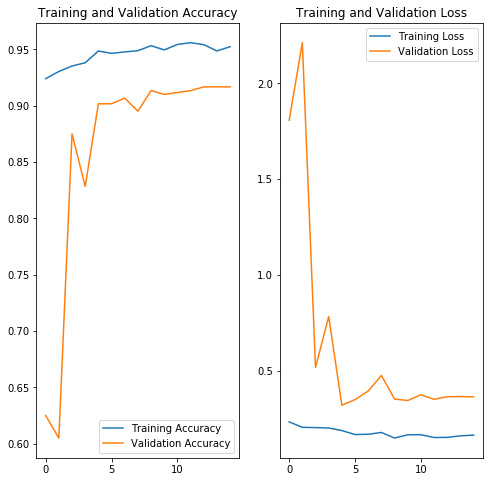

In [0]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
#Tranfer learning
img_dims = (IMG_HEIGHT, IMG_WIDTH, 3)

model_learn = Sequential()
model_learn.add(
    ResNet50(
        include_top=False, 
        pooling='avg', 
        weights='imagenet'
        )
    )
model_learn.add(
    Dense(1, activation='softmax')
)

# Say not to train first layer(ResNet) model. it is already trained
model_learn.layers[0].trainable = False

In [0]:
model_learn.compile(ptimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights_learn.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [0]:
model_learn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
history = model_learn.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=10,
    validation_data = val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[lr_reduce]
)

Epoch 1/10
52/52 [==============================] - 707s 14s/step - loss: 3.9689 - accuracy: 0.7412 - val_loss: 5.4689 - val_accuracy: 0.6433
Epoch 2/10
52/52 [==============================] - 662s 13s/step - loss: 3.9370 - accuracy: 0.7444 - val_loss: 5.4689 - val_accuracy: 0.6433
Epoch 3/10
51/52 [============================>.] - ETA: 12s - loss: 3.9725 - accuracy: 0.7422
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
52/52 [==============================] - 677s 13s/step - loss: 3.9606 - accuracy: 0.7429 - val_loss: 5.4689 - val_accuracy: 0.6433
Epoch 4/10
52/52 [==============================] - 682s 13s/step - loss: 3.9631 - accuracy: 0.7415 - val_loss: 5.4689 - val_accuracy: 0.6433
Epoch 5/10
51/52 [============================>.] - ETA: 12s - loss: 3.9866 - accuracy: 0.7400
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
52/52 [==============================] - 694s 13s/step - loss: 3.9866 - accuracy: 0.7400 - va